In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
%matplotlib notebook

In [3]:
HIDDEN_UNITS = 20

class MDN(nn.Module):
    def __init__(self, n_components):
        super(MDN, self).__init__()
        self.n_components = n_components
        self.h1 = nn.Sequential(
            nn.Linear(1, HIDDEN_UNITS),
            nn.Tanh()
        )
        self.out_pi = nn.Sequential(
            nn.Linear(HIDDEN_UNITS, n_components),
            nn.Softmax(dim=-1)
        )
        self.out_mu = nn.Linear(HIDDEN_UNITS, n_components)
        self.out_sig2 = nn.Linear(HIDDEN_UNITS, n_components)
    
    def forward(self, x):
        h1 = self.h1(x)
        pi = self.out_pi(h1)
        mu = self.out_mu(h1)
        sig2 = torch.exp(self.out_sig2(h1))
        return pi, mu, sig2

In [4]:
oneDivSqrtTwoPI = float(1.0 / np.sqrt(2.0*np.pi))
def gmm_neg_log_likelihood(pi, mu, sig2, y):
    """pi: 1xK, mu: 1xK, sig2: 1xK, y: Nx1"""
    exponent = -0.5 * (y - mu) ** 2 / sig2  # NxK
    densities = oneDivSqrtTwoPI * (torch.exp(exponent) / torch.sqrt(sig2))
    density = torch.sum(pi * densities, dim=-1)
    nnl = -torch.log(density)
    return nnl

def test_():
    pi = torch.Tensor([[1]])
    mu = torch.Tensor([[0]])
    sig2 = torch.Tensor([[1]])
    y = torch.Tensor([[-1],
                      [0],
                      [1]])
    actual = gmm_neg_log_likelihood(pi, mu, sig2, y)
    expected = [0.5, 0, 0.5]
    torch.testing.assert_allclose(actual, expected)
    
#    pi = torch.Tensor([0.5, 0.5])
#    mu = torch.Tensor([0, 0])
#    sig2 = torch.Tensor([1, 1])
#    y = torch.Tensor([-1, 0, 1])
#    actual = gmm_neg_log_likelihood(pi, mu, sig2, y)
#    expected = [0.5, 0, 0.5]
#    torch.testing.assert_allclose(actual, expected)

#test_()

In [5]:
def mdn_loss(pi, mu, sig2, y):
    likelihoods = gmm_neg_log_likelihood(pi, mu, sig2, y)
    return torch.mean(likelihoods)

def test_():
    pi = torch.Tensor([0.5, 0.5])
    mu = torch.Tensor([0, 0])
    sig2 = torch.Tensor([1, 1])
    y = torch.Tensor([-1, 0, 1])
    actual = gmm_neg_log_likelihood(pi, mu, sig2, y)
    expected = -(np.log(0.5))
    torch.testing.assert_allclose(actual, expected)

#test_()

## Data

In [6]:
n_train = 1000

epsilon = np.random.normal(size=n_train)
x_data = np.random.uniform(-10.5, 10.5, size=n_train)
y_data = 7*np.sin(0.75*x_data) + 0.5*x_data + epsilon

<IPython.core.display.Javascript object>


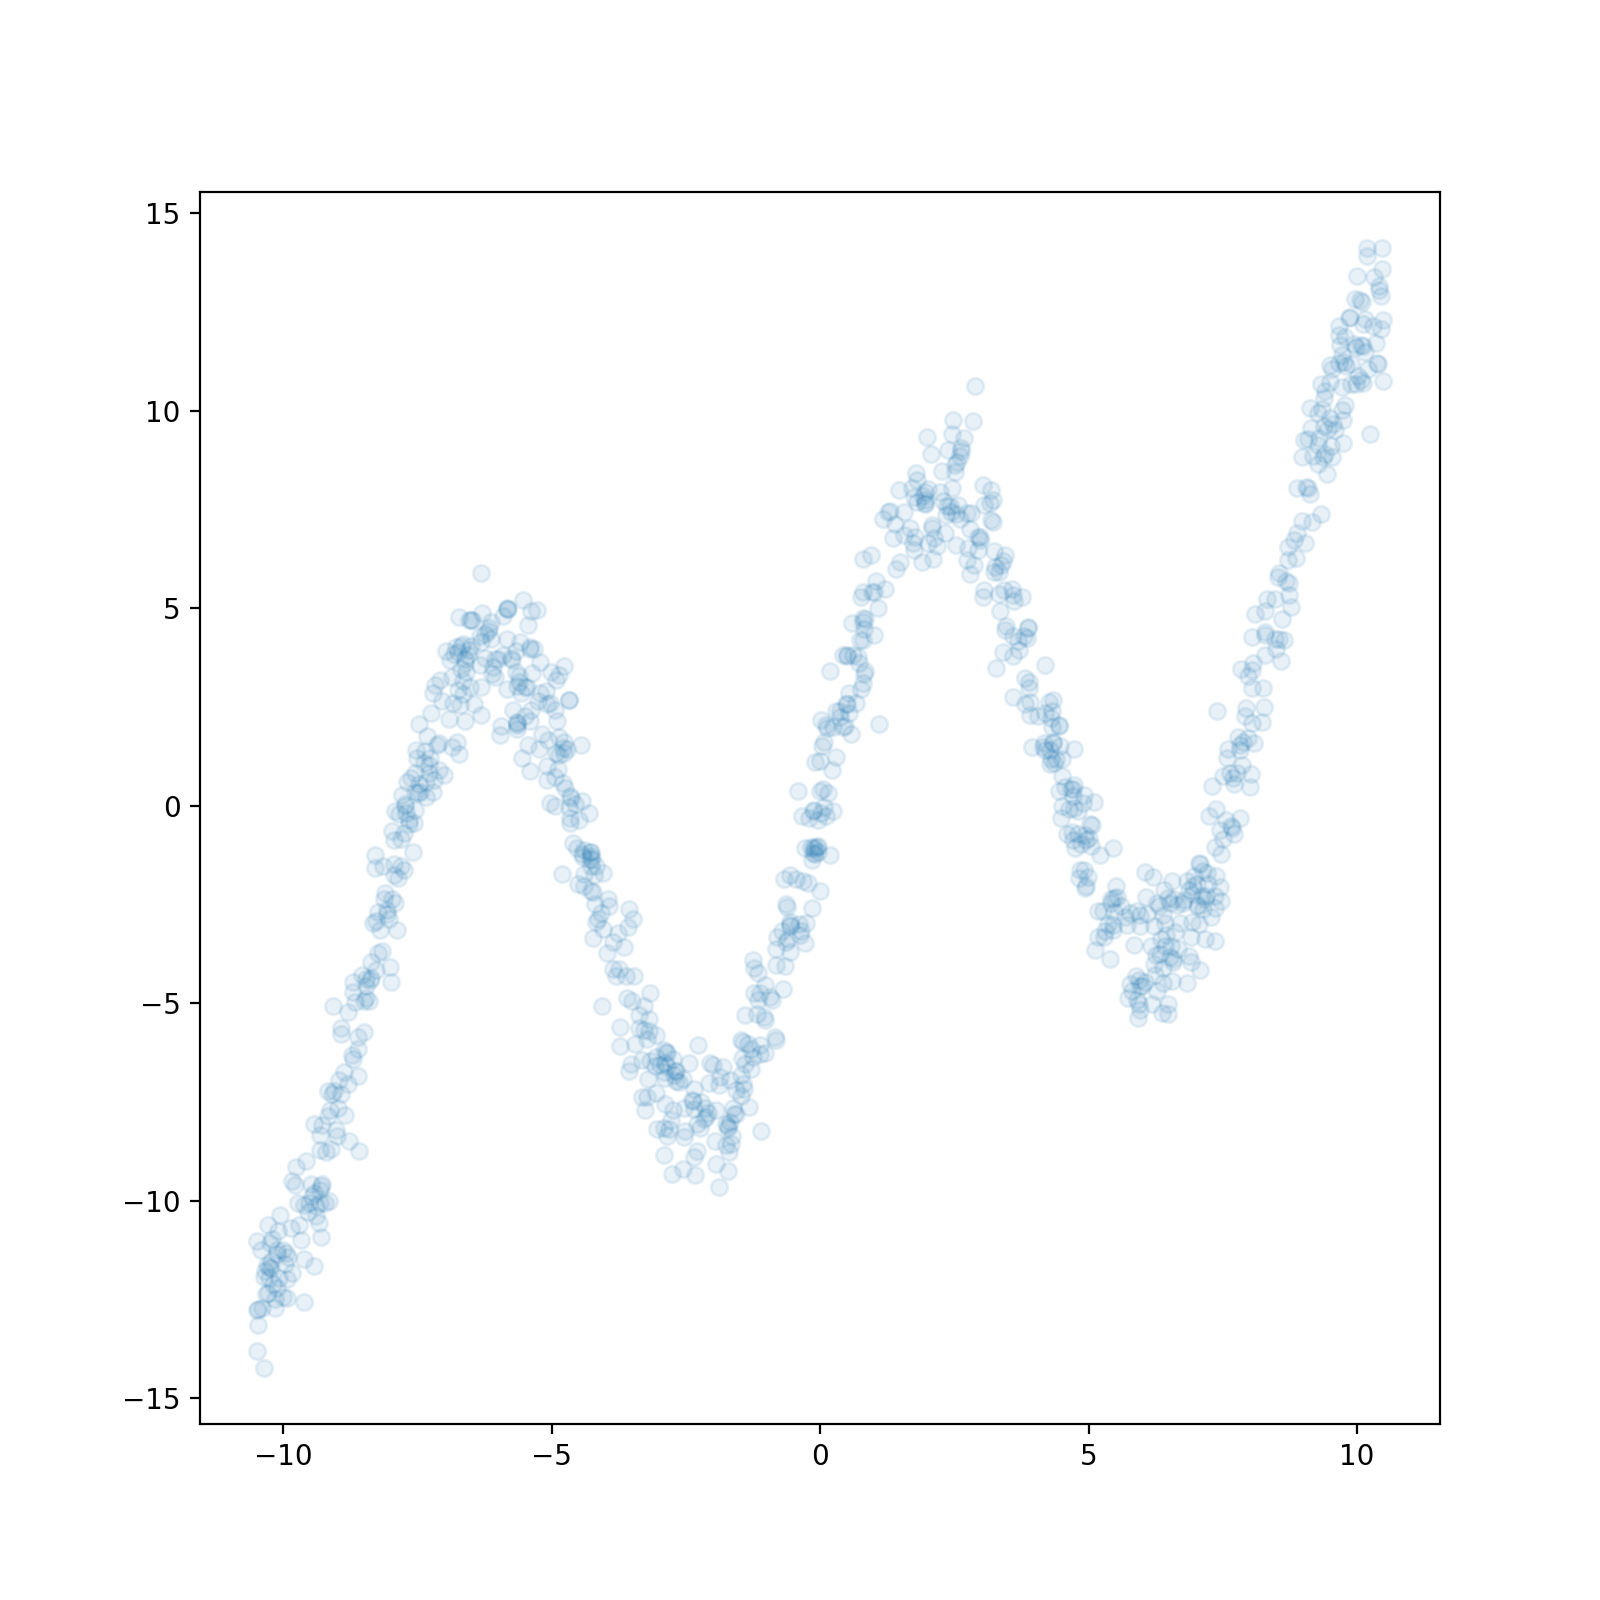

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.1)
plt.show()

In [9]:
x_data, y_data = y_data, x_data

<IPython.core.display.Javascript object>


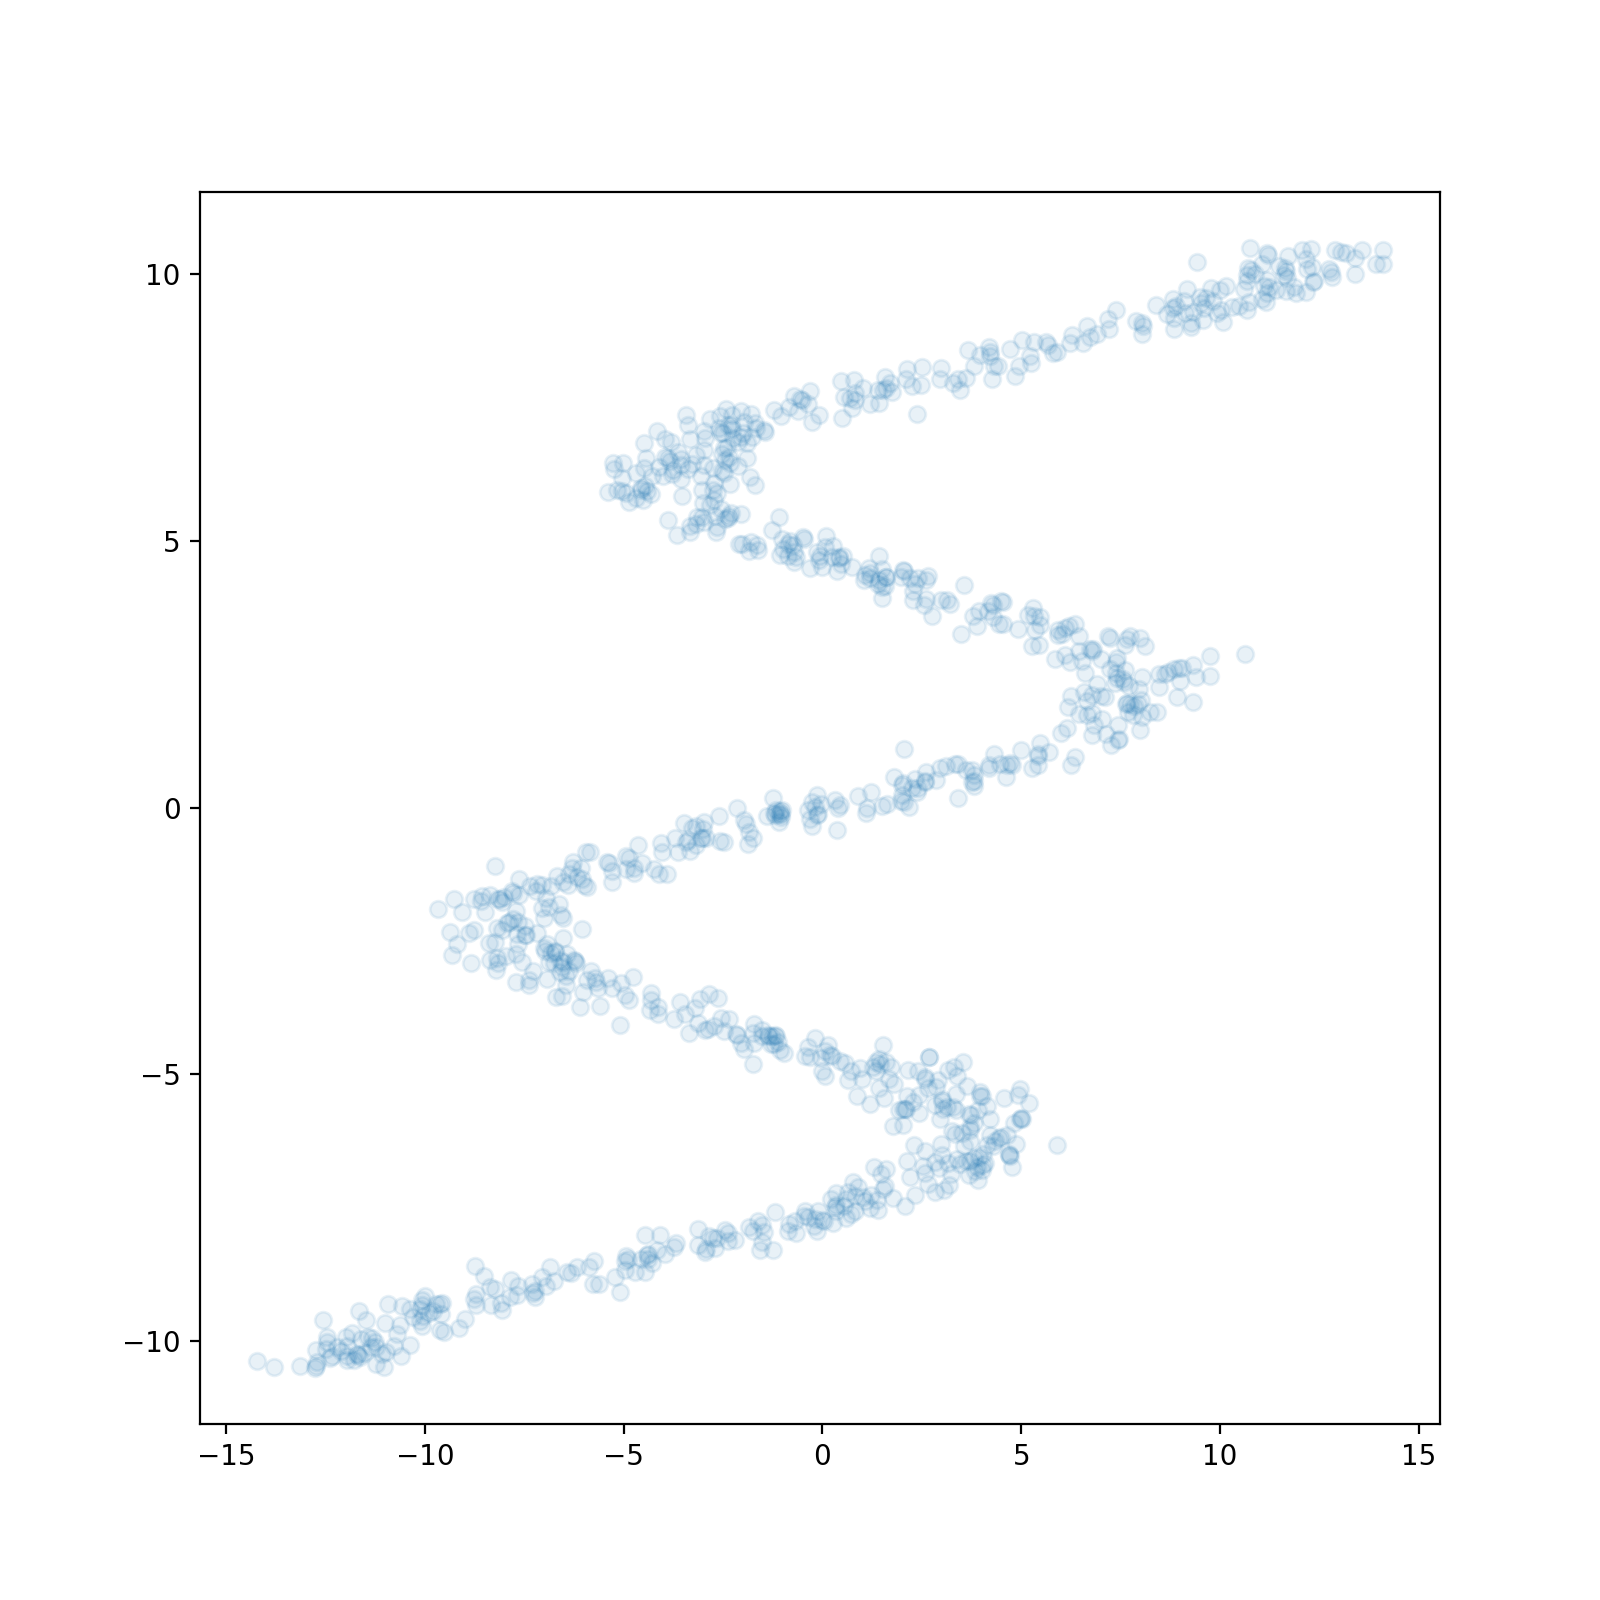

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.1)
plt.show()

## Training

In [11]:
n_epochs = 10000

def train(x_train, y_train):
    losses = np.zeros(n_epochs)
    network = MDN(n_components=5)
    optimizer = torch.optim.Adam(network.parameters())
    x_variable = Variable(torch.from_numpy(x_train[:, None].astype(np.float32)))
    y_variable = Variable(torch.from_numpy(y_train[:, None].astype(np.float32)), requires_grad=False)
    for t in range(n_epochs):
        pi, mu, sig2 = network(x_variable)
        loss = mdn_loss(pi, mu, sig2, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses[t] = loss.data[0]
        if t % 50 == 0:
            print(t, losses[t])
    return network, losses

In [12]:
network, losses = train(x_data, y_data)

/Users/dominik/Documents/Uni_Master/Courses/3.Semester/ProjectCourse/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


0 10.7692289352417
50 5.664976119995117
100 4.238987445831299
150 3.744861125946045
200 3.504723310470581
250 3.364591360092163
300 3.2743027210235596
350 3.2115676403045654
400 3.164945125579834
450 3.128201484680176
500 3.0977511405944824
550 3.071298122406006
600 3.0469272136688232
650 3.0222702026367188
700 2.9950246810913086
750 2.9678938388824463
800 2.942657947540283
850 2.9160709381103516
900 2.8848986625671387
950 2.8455514907836914
1000 2.7962396144866943
1050 2.743989944458008
1100 2.6998846530914307
1150 2.664377212524414
1200 2.634190320968628
1250 2.6082420349121094
1300 2.585404396057129
1350 2.5639500617980957
1400 2.5429389476776123
1450 2.522190570831299
1500 2.50181245803833
1550 2.482522487640381
1600 2.465008020401001
1650 2.4494497776031494
1700 2.4357481002807617
1750 2.423614025115967
1800 2.412611722946167
1850 2.4023241996765137
1900 2.392549514770508
1950 2.3832080364227295
2000 2.3740530014038086
2050 2.364689826965332
2100 2.3547332286834717
2150 2.34379291

<IPython.core.display.Javascript object>


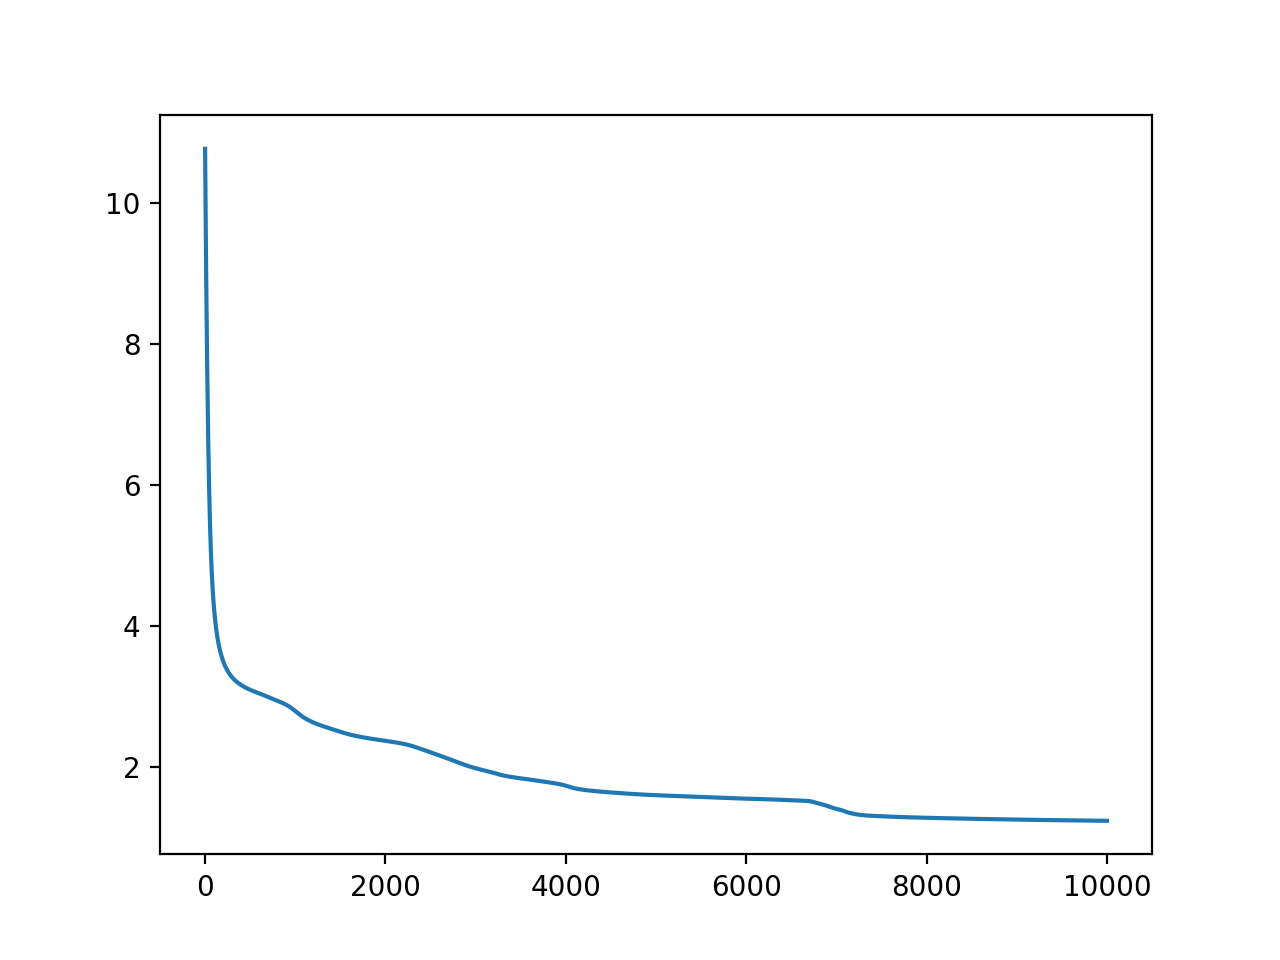

In [13]:
plt.figure()
plt.plot(np.arange(n_epochs), losses)
plt.show()

## Evaluation

In [23]:
n_test = 1000

In [24]:
x_test = np.linspace(-15, 15, n_test)
pi, mu, sig2 = [x.data.numpy() for x in network(torch.Tensor(x_test[:, None]))]

In [25]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi)
mu_sampled = mu[np.arange(n_test), k]
sig2_sampled = sig2[np.arange(n_test), k]
gmm_sampled = np.random.randn(n_test) * sig2_sampled + mu_sampled

<IPython.core.display.Javascript object>


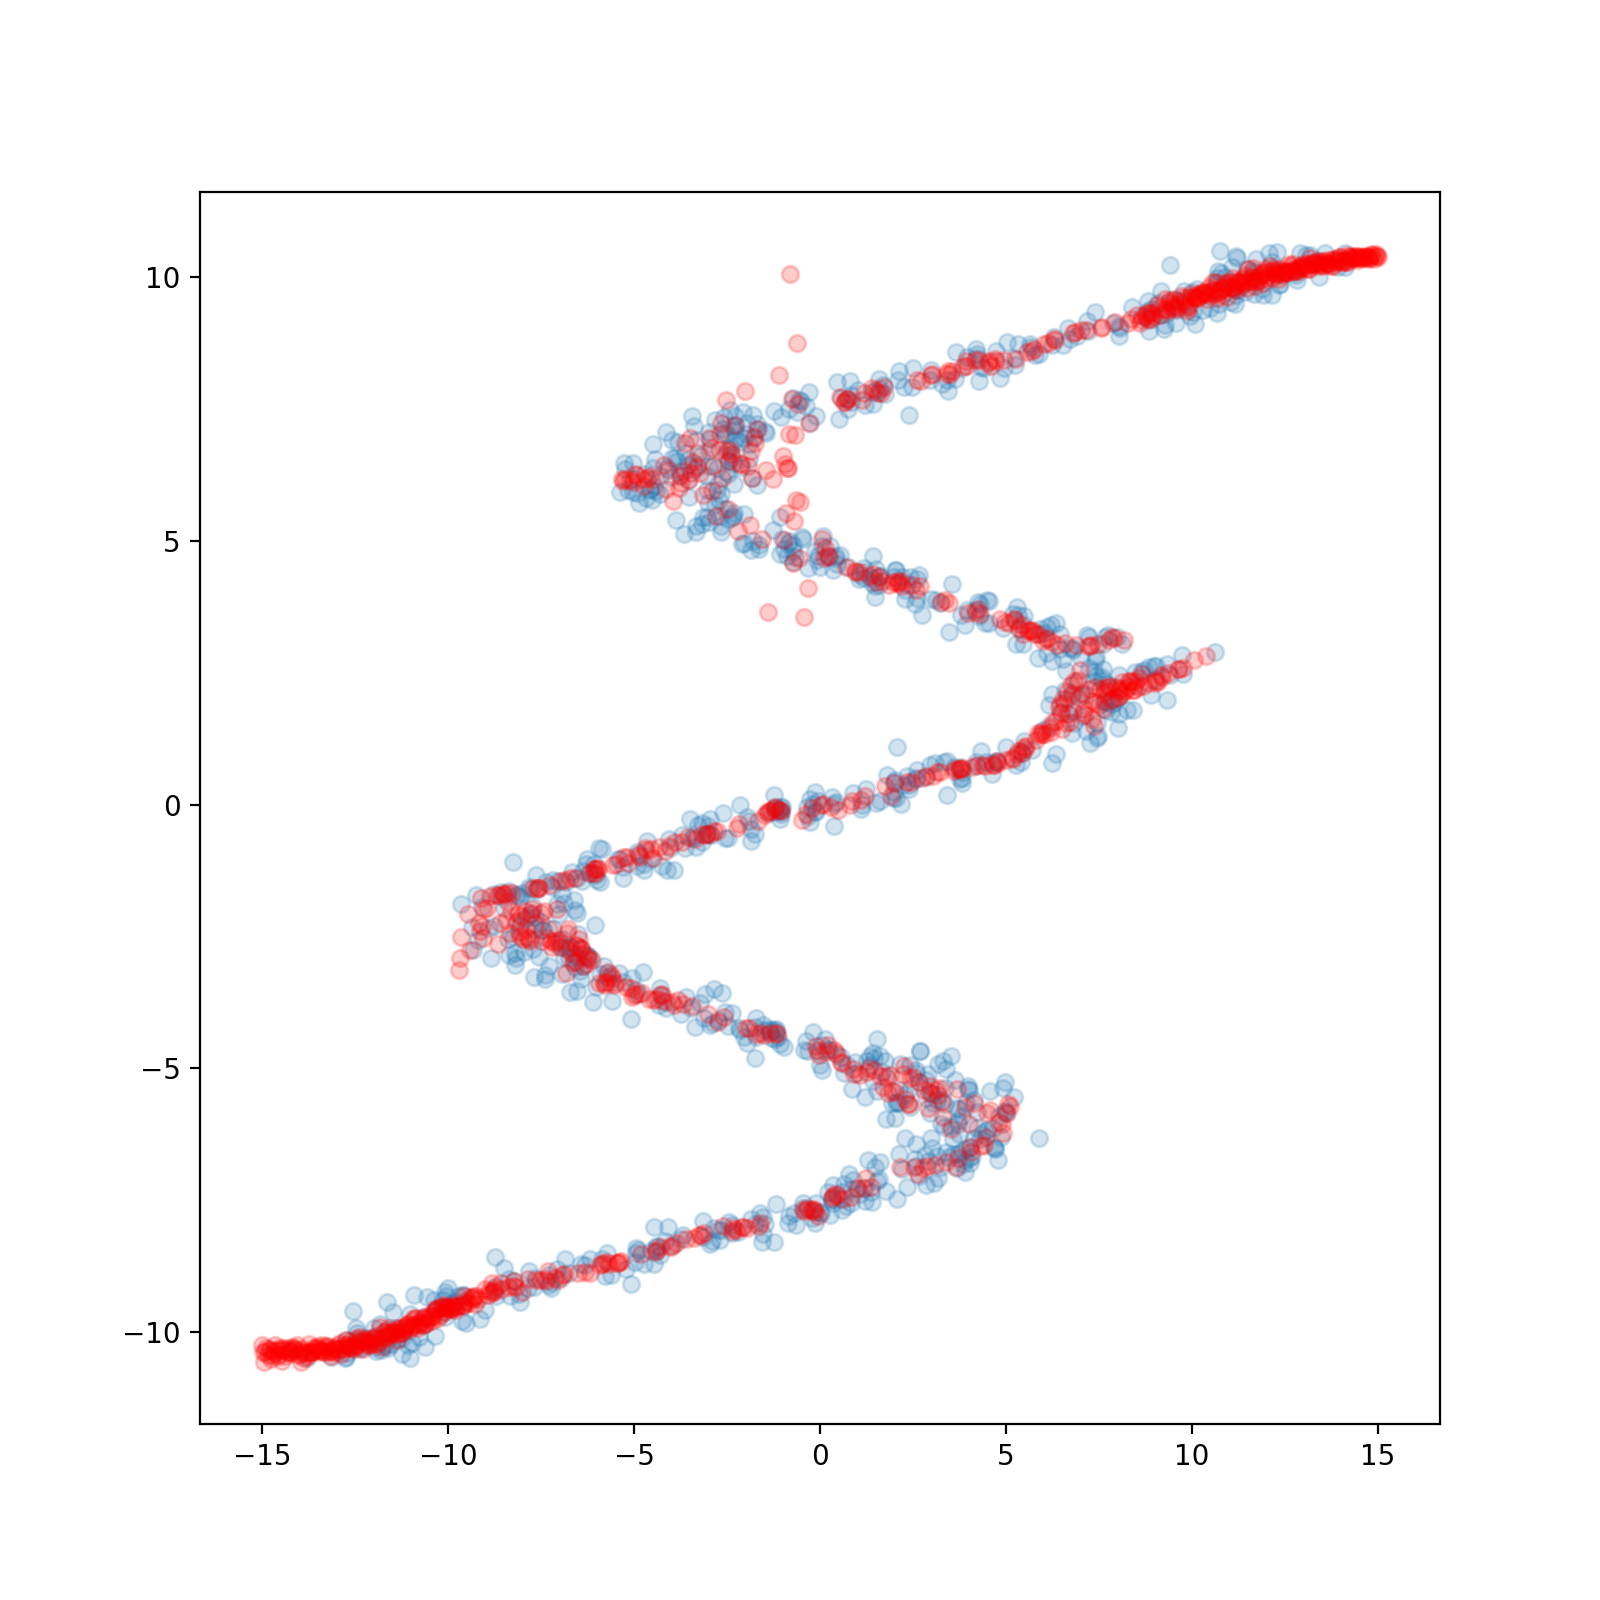

In [27]:
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.2)
plt.scatter(x_test, gmm_sampled, alpha=0.2, c='red')
plt.show()